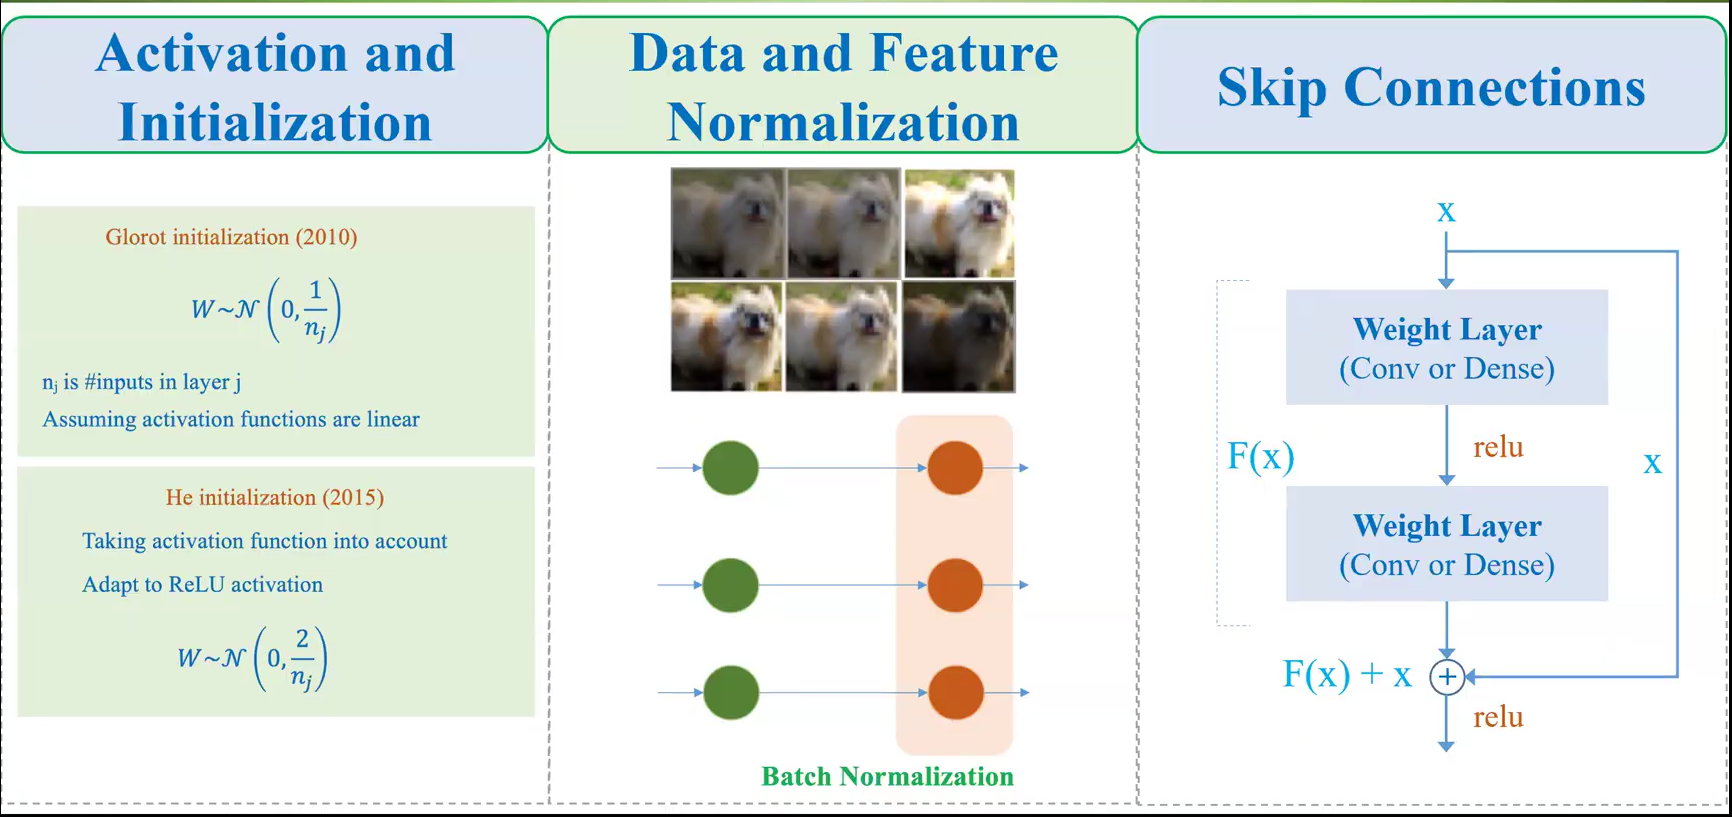

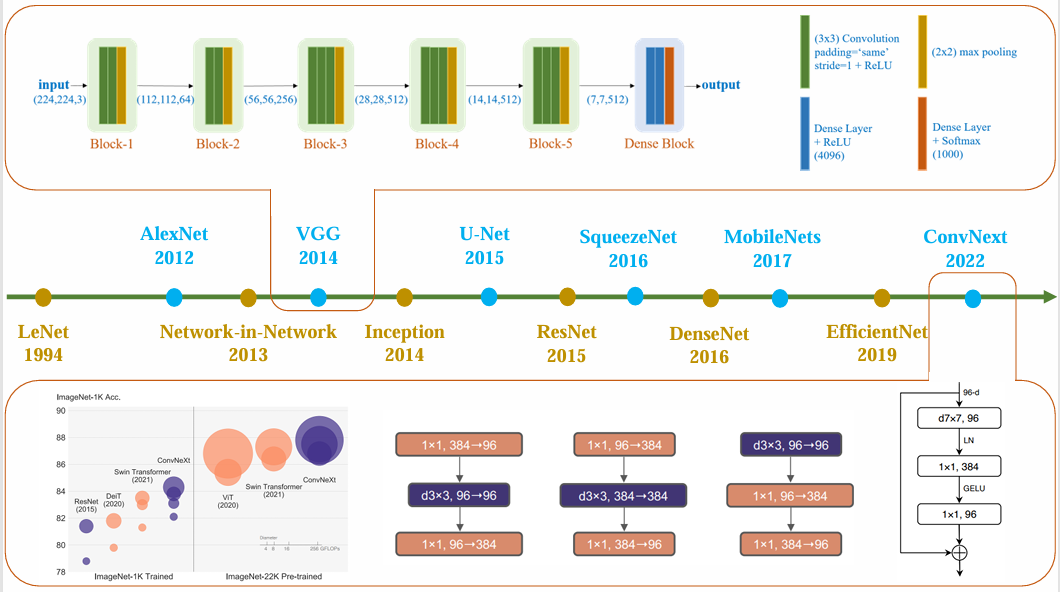

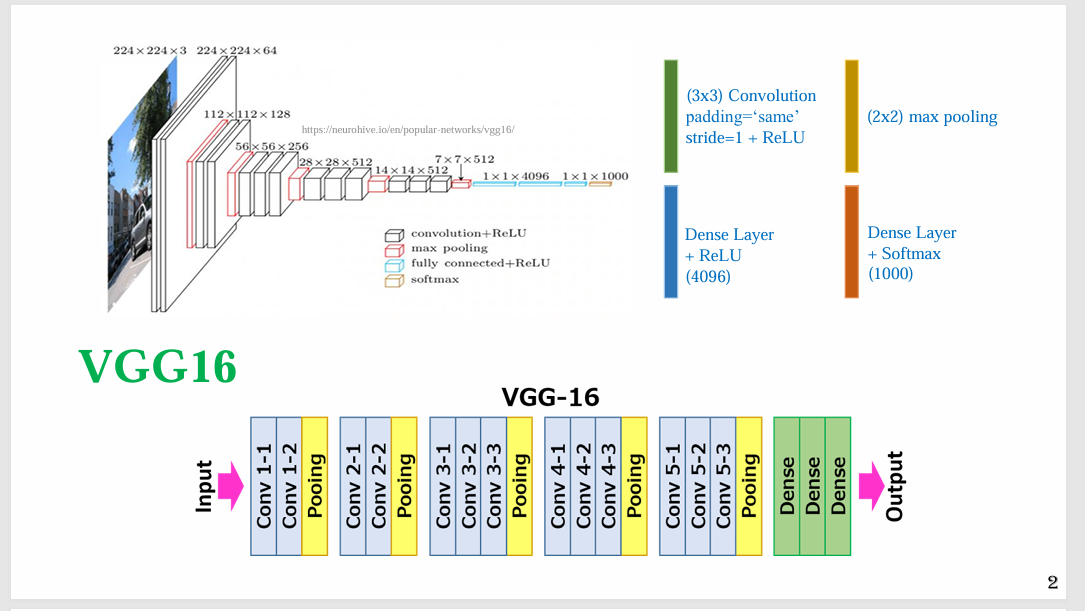

# Architecture 

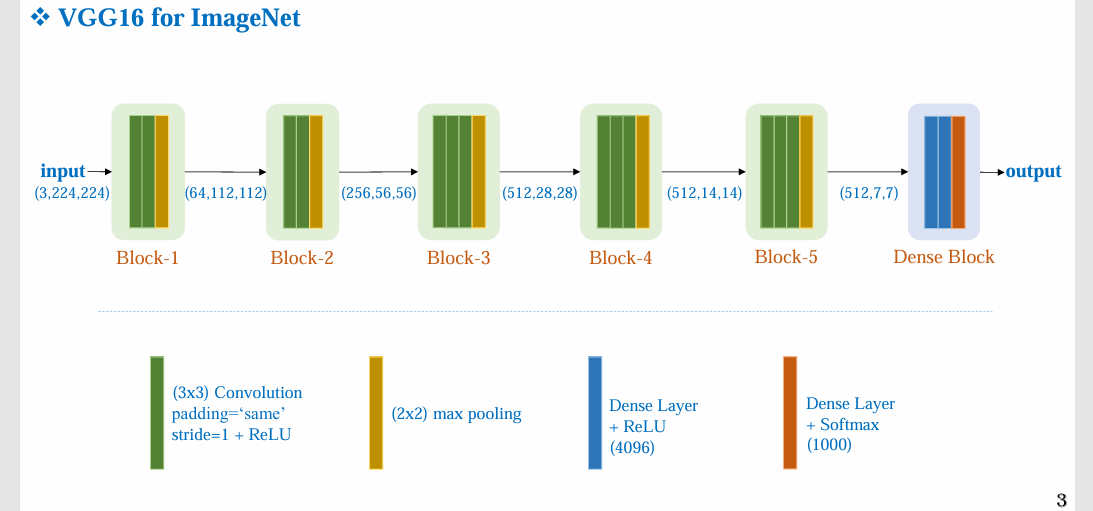

# implementation

In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

In [2]:
block1 = torch.nn.Sequential(
    torch.nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1),  #(3, 224, 224) -> (64, 224, 224)
    torch.nn.ReLU(inplace=True),    # Relu modify the input tensor directly
    torch.nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),  #(65, 224, 224) -> (64, 224, 224)
    torch.nn.ReLU(inplace=True),
    torch.nn.MaxPool2d(kernel_size=2, stride=2)     #(64, 224, 224) -> (64, 112, 112)
)

block2 = torch.nn.Sequential(
    torch.nn.Conv2d(in_channels=64, out_channels=256, kernel_size=3, padding=1),  #(256, 112, 112)
    torch.nn.ReLU(inplace=True),    # Relu modify the input tensor directly
    torch.nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),  #(256, 112, 112)
    torch.nn.ReLU(inplace=True),
    torch.nn.MaxPool2d(kernel_size=2, stride=2)     #(256, 56, 56)
)


block3 = torch.nn.Sequential(
    torch.nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1),  
    torch.nn.ReLU(inplace=True),    # Relu modify the input tensor directly
    torch.nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),  
    torch.nn.ReLU(inplace=True),
    torch.nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),  
    torch.nn.ReLU(inplace=True),
    torch.nn.MaxPool2d(kernel_size=2, stride=2)        #(512, 28, 28)
)

block4 = torch.nn.Sequential(
    torch.nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),  
    torch.nn.ReLU(inplace=True),    # Relu modify the input tensor directly
    torch.nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),  
    torch.nn.ReLU(inplace=True),
    torch.nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),  
    torch.nn.ReLU(inplace=True),
    torch.nn.MaxPool2d(kernel_size=2, stride=2)        #(512, 14, 14)
)

block5 = torch.nn.Sequential(
    torch.nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),  
    torch.nn.ReLU(inplace=True),    # Relu modify the input tensor directly
    torch.nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),  
    torch.nn.ReLU(inplace=True),
    torch.nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),  
    torch.nn.ReLU(inplace=True),
    torch.nn.MaxPool2d(kernel_size=2, stride=2)        #(512, 7, 7)
)

classifier = torch.nn.Sequential(
    torch.nn.Flatten(),
    torch.nn.Linear(512*7*7, 4096),
    torch.nn.ReLU(inplace=True),
    torch.nn.Linear(4096, 4096),
    torch.nn.ReLU(inplace=True),
    torch.nn.Linear(4096, 1000),
)


In [3]:
class VGG16(torch.nn.Module):
    def __init__(self):
        super(VGG16, self).__init__()
        self.block1 = block1
        self.block2 = block2
        self.block3 = block3
        self.block4 = block4
        self.block5 = block5
        self.classifier = classifier

    def foward(self, x):
        x = self.block1
        x = self.block2
        x = self.block3
        x = self.block4
        x = self.block5
        x =self.classifier
        return x
model = VGG16()

# Solution

# Solution 1 : Normalization all image in dataset

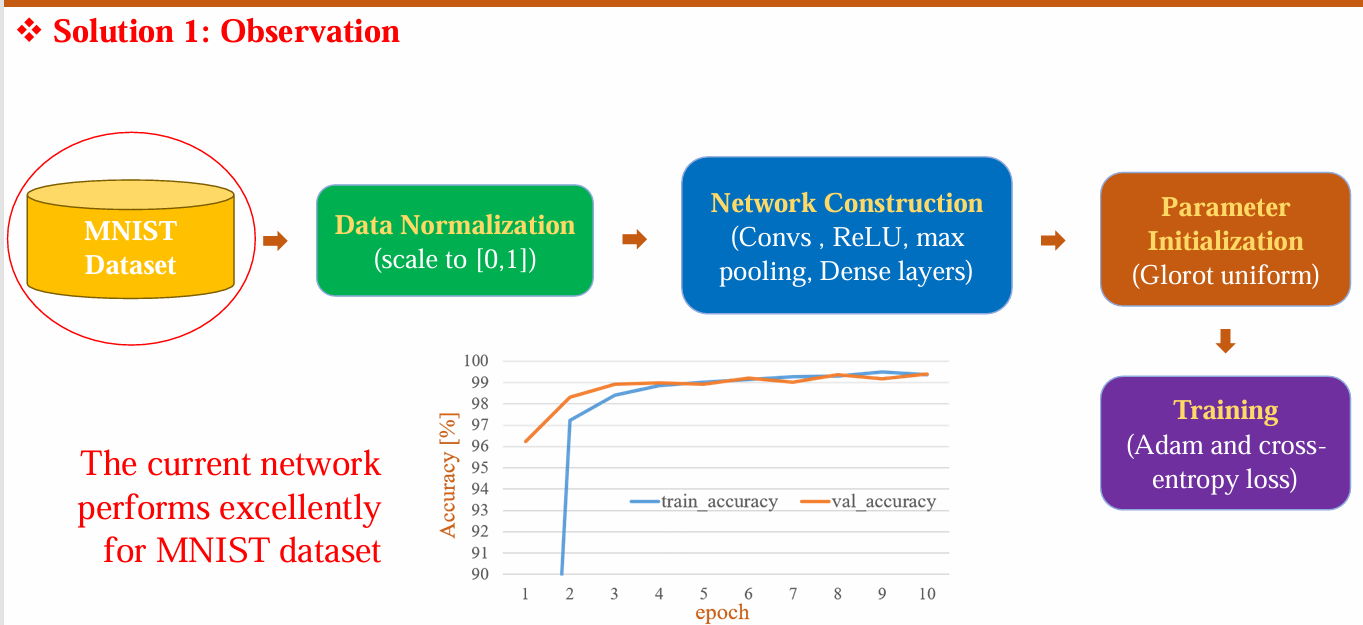

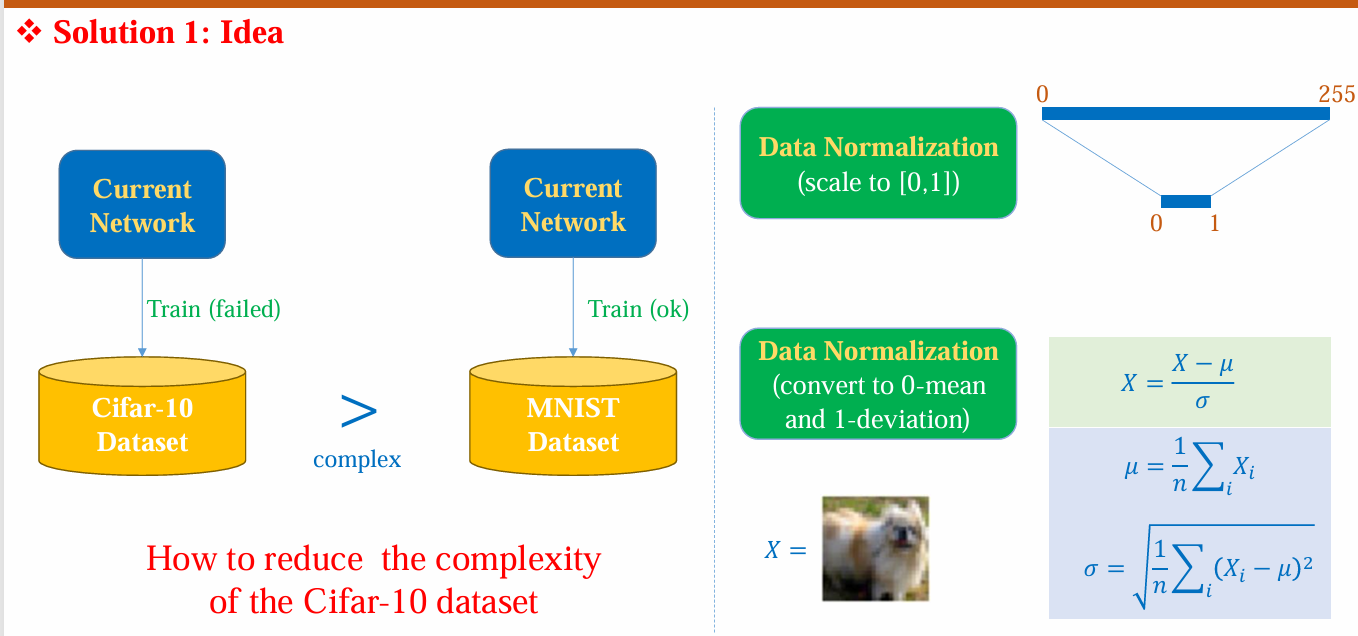

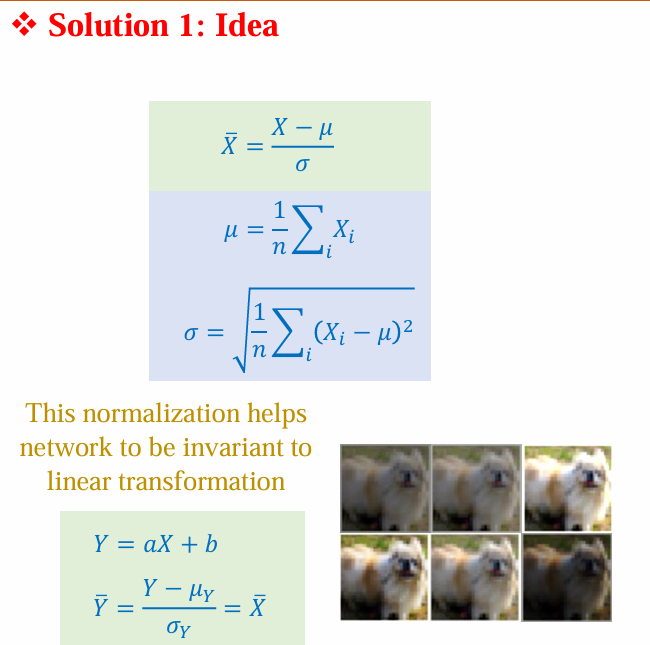

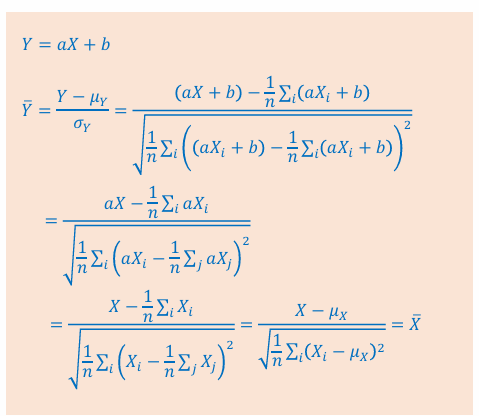

In [4]:
import torchvision

In [68]:
compute_train = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])
dataset = torchvision.datasets.CIFAR10(root='data_cifar10', 
                                       train=True,
                                       download=True,
                                       transform=compute_train)
loader = torch.utils.data.DataLoader(dataset, 
                                     batch_size=1024,
                                     shuffle=False,
                                     num_workers=4)

# compute mean of all image train
mean = 0
for images,_ in loader:
    batch_sample = images.size(0)   #batch_size
    images = images.view(batch_sample, images.size(1), -1)  #848 image, (image.shape = (848, 3, 1024) with 1024 = 32 * 32)
    mean += images.mean(2).sum(0)   # mean(2) : RGB in channel 2: 1024 and sum in 3 channel RGB
mean = mean/len(loader.dataset)

variance = 0
for images, _ in loader:
    batch_sample = images.size(0)
    images = images.view(batch_sample, images.size(1), -1)
    variance += ((images - mean.unsqueeze(1))**2).sum([0,2])
std = torch.sqrt(variance / len(loader.dataset)*32*32)

In [67]:
print(batch_sample)
print(images.shape)
print()
print(mean.shape)
print(mean.unsqueeze(1).shape)
print('variance: ', variance)
print(len(loader.dataset))

848
torch.Size([848, 3, 1024])

torch.Size([3])
torch.Size([3, 1])
variance:  tensor([3124476.2500, 3035392.7500, 3503524.0000])
50000


In [69]:
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor(), 
                                           torchvision.transforms.Normalize(mean, std)])

train_set = torchvision.datasets.CIFAR10(root='data_cifar10', train=True,
                                         download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=256,
                                           shuffle=True, num_workers=4)

# Solution 2: Normalization mini-batch <br>
EX: batch 1 (6 sample): theta0 -> normalize (6 sample) with theta0 <br>
batch 2 (6 sample): theta1 -> normalize (6 sample) with theta1 <br>

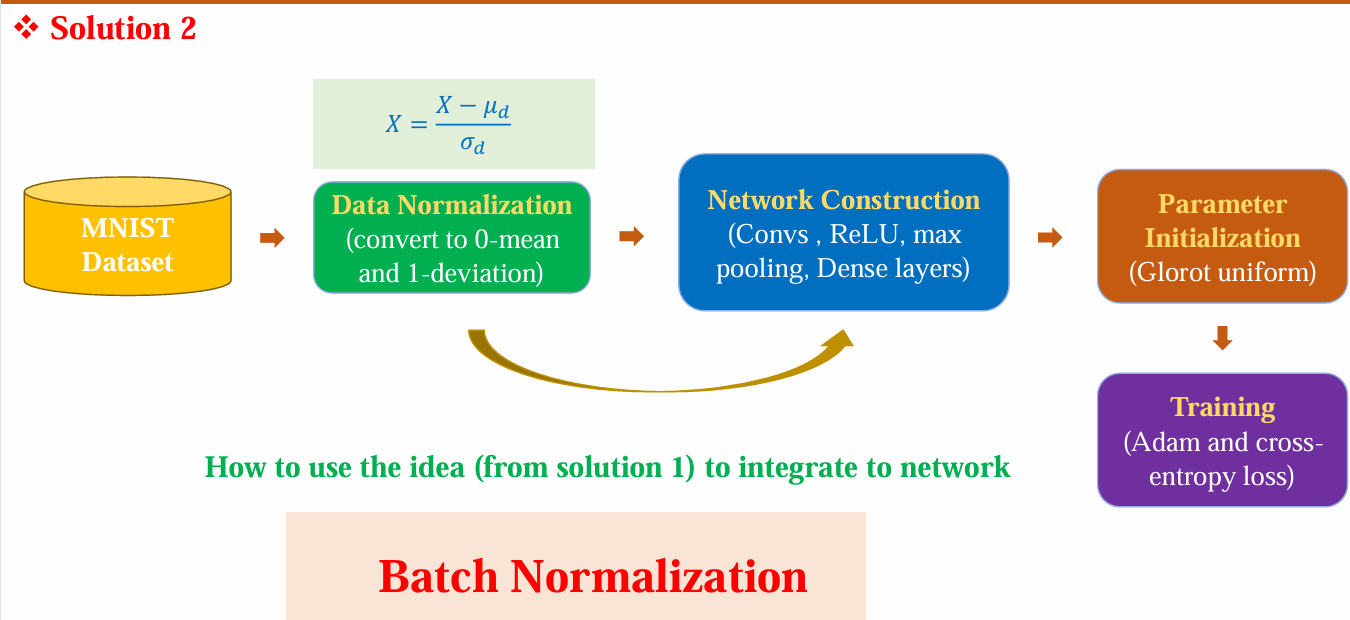

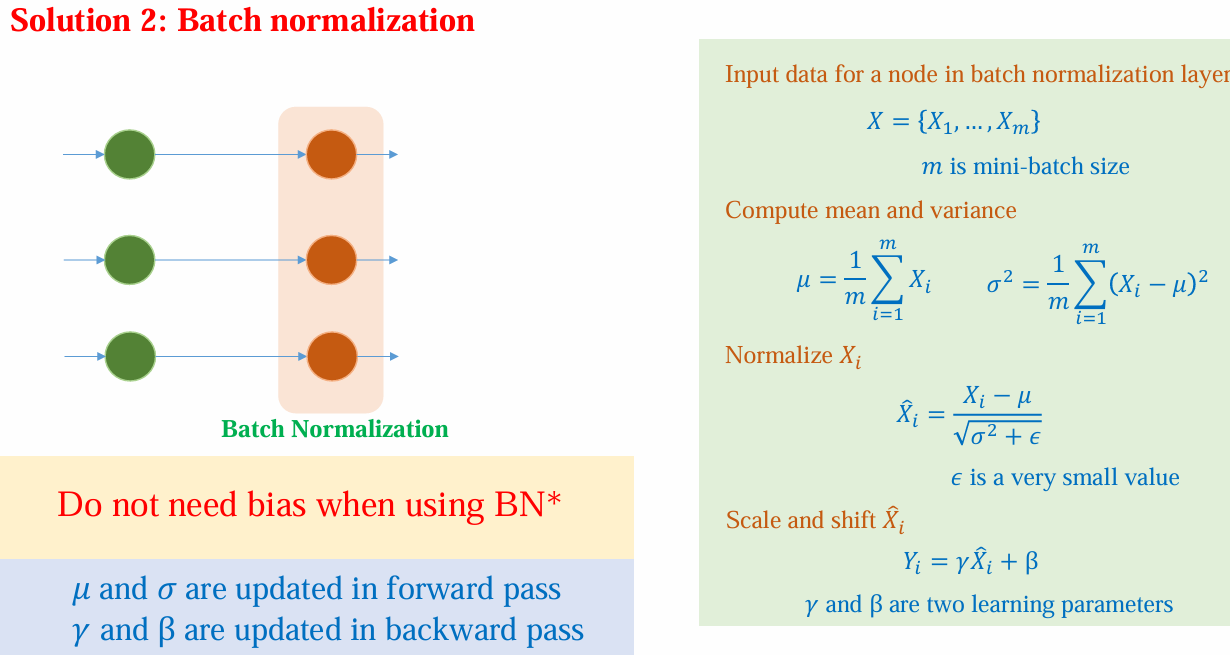

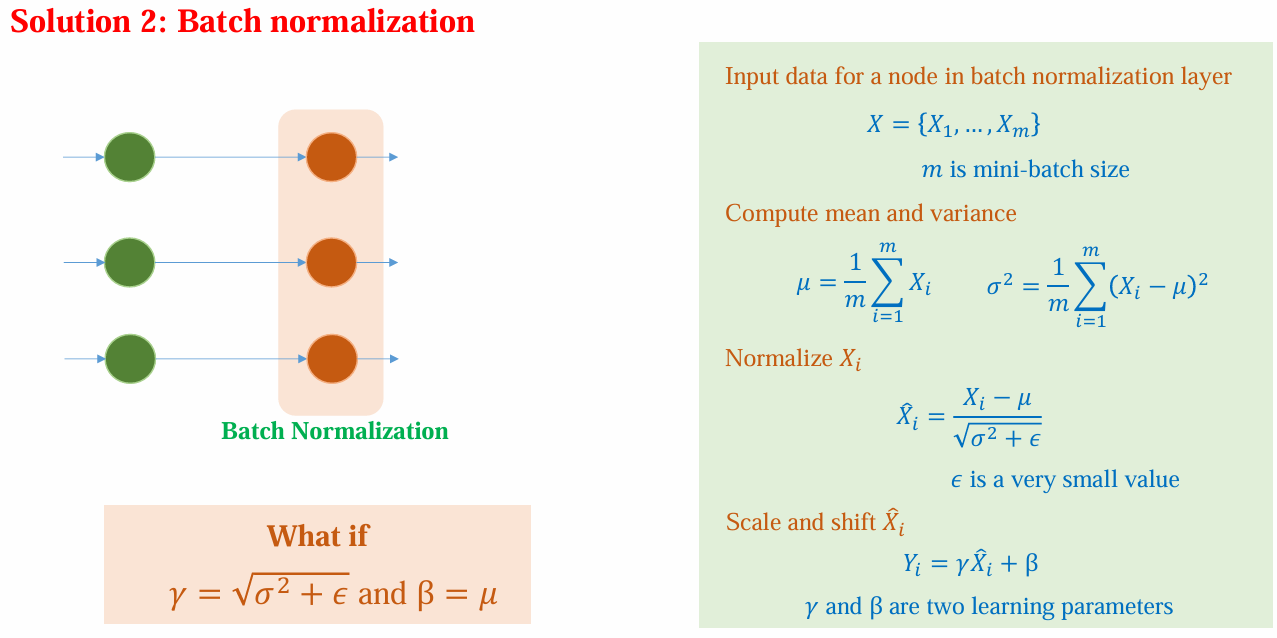

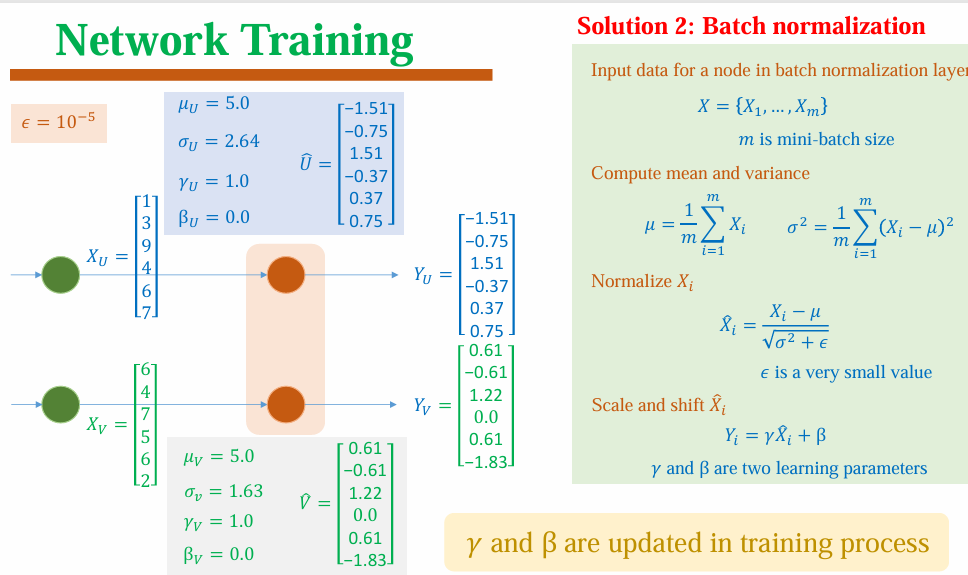

N (sample) is number of images be effected by K1 <br>
H,W is height and width of image

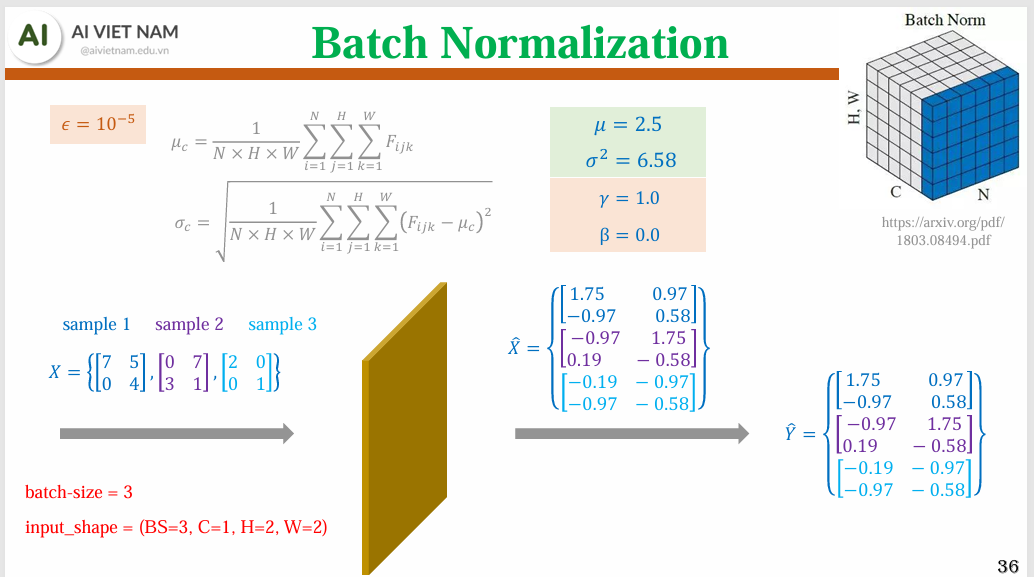

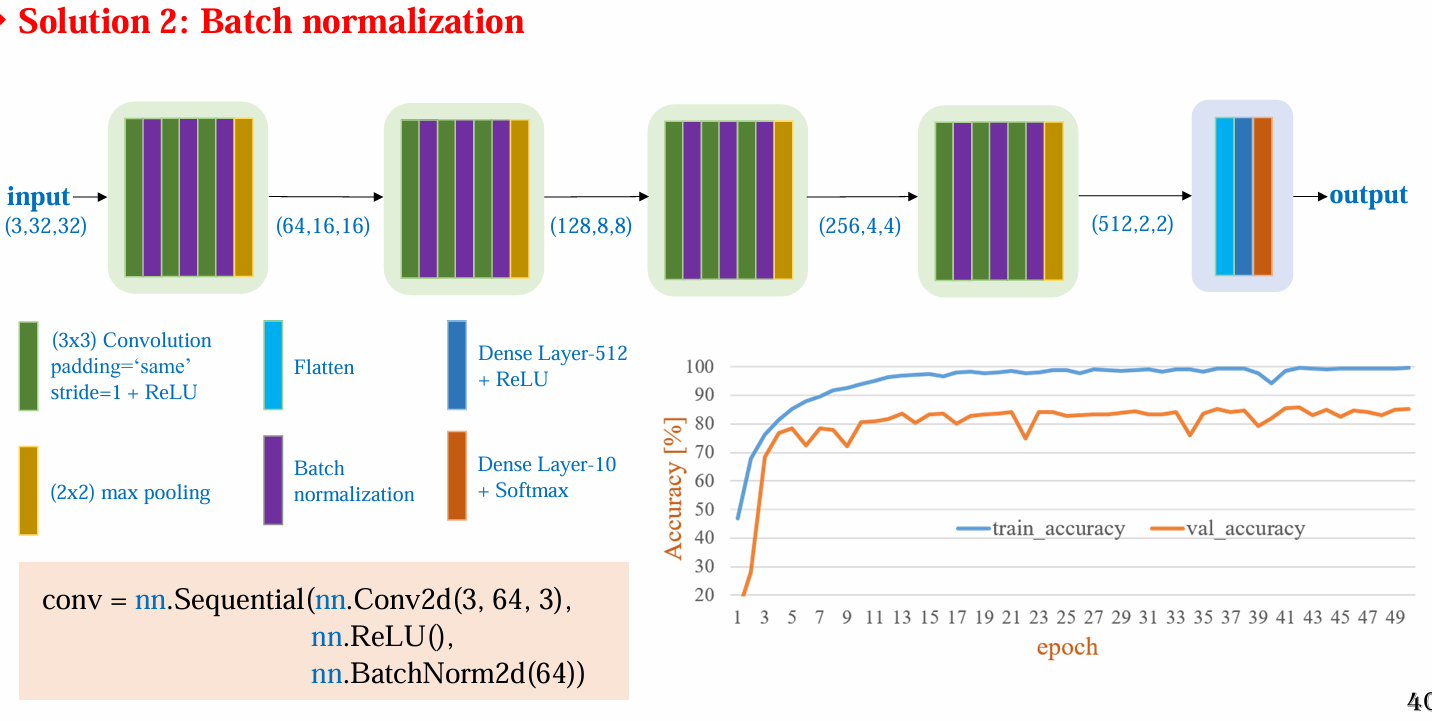

In [74]:
conv_layer1 = nn.Sequential(
    nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.BatchNorm2d(64), #num feature
)

conv_layer2 = nn.Sequential(
    nn.Conv2d(64, 64, 3, stride=1, padding=1),
    nn.ReLU(),
    nn.BatchNorm2d(64),
)

conv_layer3 = nn.Sequential(
    nn.Conv2d(64, 64, 3, stride=1, padding=1),
    nn.ReLU(),
    nn.BatchNorm2d(64),
    nn.MaxPool2d(kernel_size=2, stride=2)
)